In [1]:
import re
import jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import requests
from bs4 import BeautifulSoup
import csv
import pprint
import requests

# 显示中文
from set_font import set_chinese_font
custom_font_path = 'Times_SimSun.ttf'
set_chinese_font(custom_font_path)

## 数据获取

In [2]:
# csv模块保存数据到Excel
f = open('去哪儿网——苏州篇.csv', mode='a', encoding='utf-8', newline='')
csv_writer = csv.DictWriter(f, fieldnames=['景点名称', '攻略数量', '点评数量', '景点排名', '驴友去过',
                                           '星级', '描述','综合评分'])
csv_writer.writeheader()    #写入表头

# 获取每页的网址
# 模拟浏览器发送请求
ui = 'https://travel.qunar.com/p-cs299937-suzhou-jingdian'
headers = {
    'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Mobile Safari/537.36 Edg/124.0.0.0'
}

In [3]:
if False:
    for i in range(1,20):
        url=f'{ui}-1-{str(i)}'
    
        response = requests.get(url, headers)
        content=response.text
        soup = BeautifulSoup(content,'lxml')
        infor = soup.find('ul',class_ = "list_item clrfix").find_all('li')
        data_jd = []
        
        # 获取苏州不同旅游景点的属性
        for i in infor:
            dic = {}
            data_jd=[]
            name = i.find('span', class_="cn_tit").text                                      #景点名称
            gonglue_amount = i.find('div', class_="strategy_sum").text                       #景点攻略提到数量
            dianping_amount = i.find('div', class_="comment_sum").text                       #景点点评数量
            rating_num = i.find('span', class_="ranking_sum").text[7:]                       #景点排名
            Hikers = i.find('span', class_="sum").text.split('%')[0]                         #驴友去过
            star = i.find('span', class_="cur_star")['style'].split(':')[1].split('%')[0]    #景点星级
            description = i.find('div', class_="desbox").text                                #景点一句话描述
            #lianjie = i.find('a')['href']
            dic = {
                '景点名称': name,
                '攻略数量': gonglue_amount,
                '点评数量': dianping_amount,
                '景点排名': rating_num,
                '驴友去过': Hikers,
                '星级': star,
                '描述': description,
                # '综合评分':score
            }

## 预处理

In [4]:
df = pd.read_csv('data/去哪儿网——苏州篇.csv')
df

,景点名称,攻略数量,点评数量,景点排名,驴友去过,星级,描述,综合评分
0,苏州博物馆Suzhou Museum,239,2522,3.0,45,94,由贝聿铭设计的新馆清新雅致，欣赏镇馆之宝越窑秘色瓷莲花碗。,117.9
1,拙政园Humble Administrator's Garden,346,12983,1.0,66,92,“中国四大名园”之一，世界文化遗产。,157.8
2,寒山寺Hanshan Temple,152,3147,4.0,39,92,千年名寺，诗句“姑苏城外寒山寺”的出处，来此撞钟、祈福。,88.8
3,观前街Guanqian Street,192,1299,1.0,19,90,松鹤楼、黄天源，苏州老字号里吃美食；游览街名的来源玄妙观。,92.2
4,周庄Zhouzhuang,7,7975,1.0,19,90,小桥流水与人家，双桥水巷摇橹船，还有沈万三的足迹待你寻访。,36.7
...,...,...,...,...,...,...,...,...
95,松石悟园Songshi Enlightenment Garden,2,70,11.0,0,80,NaN,24.6
96,生命奥秘博物馆Mystery of Life Museum,1,74,6.0,0,90,看震撼的动物、人体标本，了解肌肉、骨骼、内脏结构。,27.3
97,世德堂(同里明清街店)shi de tang,2,26,12.0,0,88,NaN,27.0
98,五人之墓Wuren Tomb,1,14,188.0,0,90,NaN,27.3


In [5]:
df['描述'].fillna('暂无数据', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   景点名称    100 non-null    object 
 1   攻略数量    100 non-null    int64  
 2   点评数量    100 non-null    int64  
 3   景点排名    97 non-null     float64
 4   驴友去过    100 non-null    int64  
 5   星级      100 non-null    int64  
 6   描述      100 non-null    object 
 7   综合评分    100 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 6.4+ KB


In [7]:
df.describe()

,攻略数量,点评数量,景点排名,驴友去过,星级,综合评分
count,100.000000,100.000000,97.000000,100.000000,100.000000,100.0000
mean,30.240000,762.530000,49.103093,4.880000,87.900000,37.3940
std,65.320827,1748.940294,107.413384,11.799058,10.534695,24.7495
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.3000
25%,2.000000,60.750000,5.000000,0.000000,88.000000,27.3750
50%,5.000000,159.000000,15.000000,0.000000,90.000000,28.6500
75%,17.250000,661.750000,43.000000,2.000000,92.000000,33.5500
max,346.000000,12983.000000,711.000000,66.000000,100.000000,157.8000


## 可视化

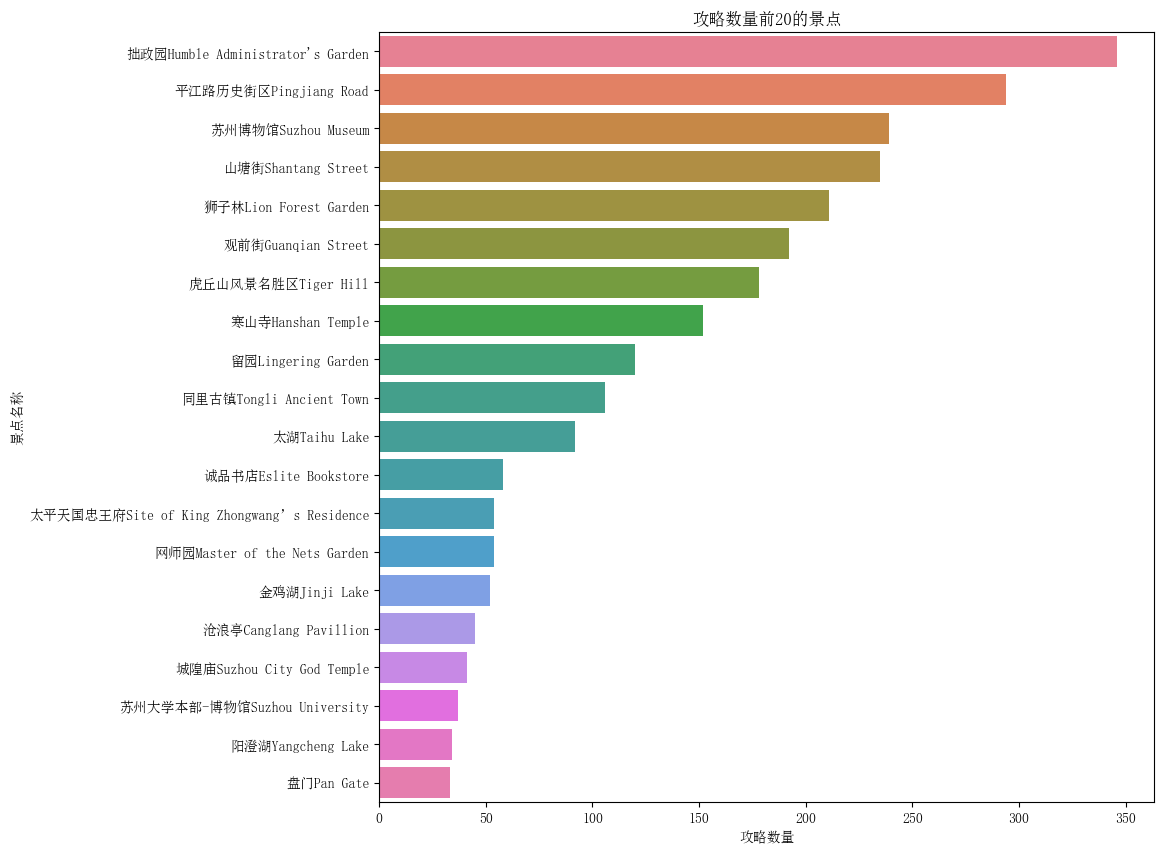

In [8]:
plt.figure(figsize=(10,10))
sns.barplot(data=df.sort_values('攻略数量',ascending=False).head(20), y='景点名称', x='攻略数量', hue='景点名称')
plt.title('攻略数量前20的景点')
plt.show()

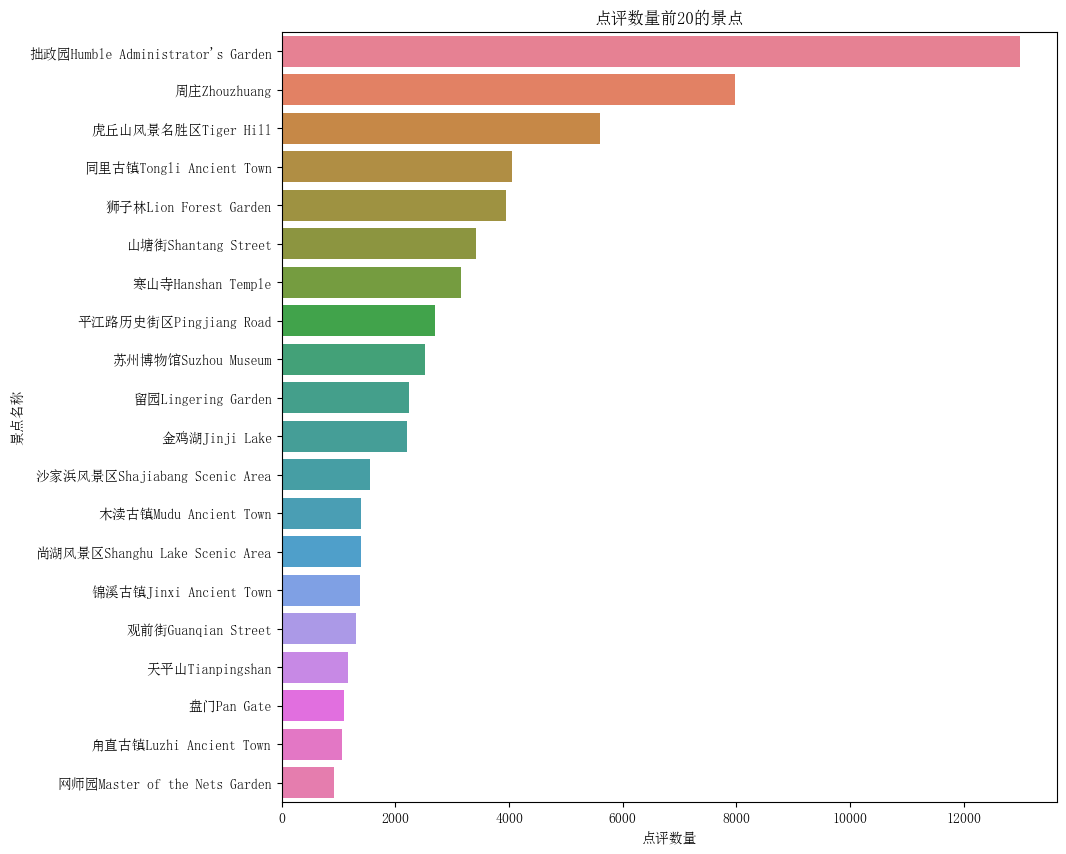

In [9]:
plt.figure(figsize=(10,10))
sns.barplot(data=df.sort_values('点评数量',ascending=False).head(20), y='景点名称', x='点评数量', hue='景点名称')
plt.title('点评数量前20的景点')
plt.show()

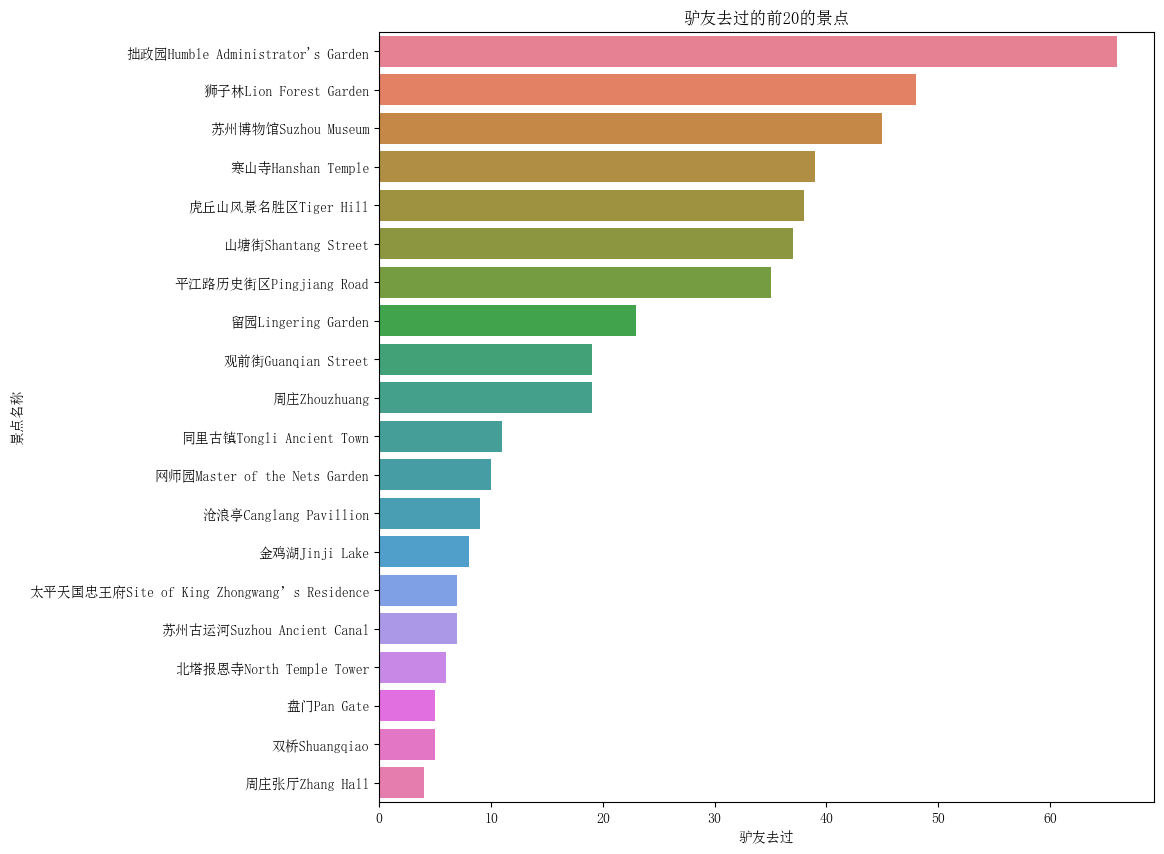

In [10]:
plt.figure(figsize=(10,10))
sns.barplot(data=df.sort_values('驴友去过',ascending=False).head(20), y='景点名称', x='驴友去过', hue='景点名称')
plt.title('驴友去过的前20的景点')
plt.show()

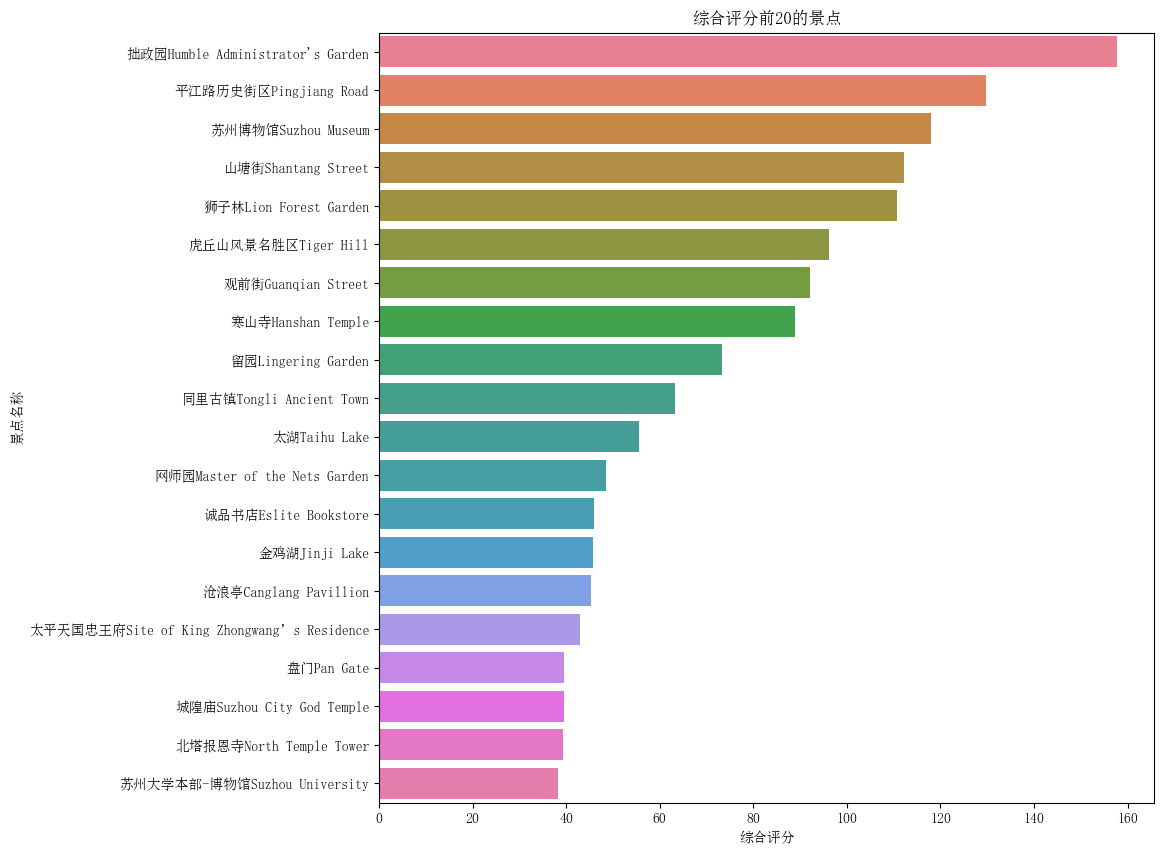

In [11]:
plt.figure(figsize=(10,10))
sns.barplot(data=df.sort_values('综合评分',ascending=False).head(20), y='景点名称', x='综合评分', hue='景点名称')
plt.title('综合评分前20的景点')
plt.show()

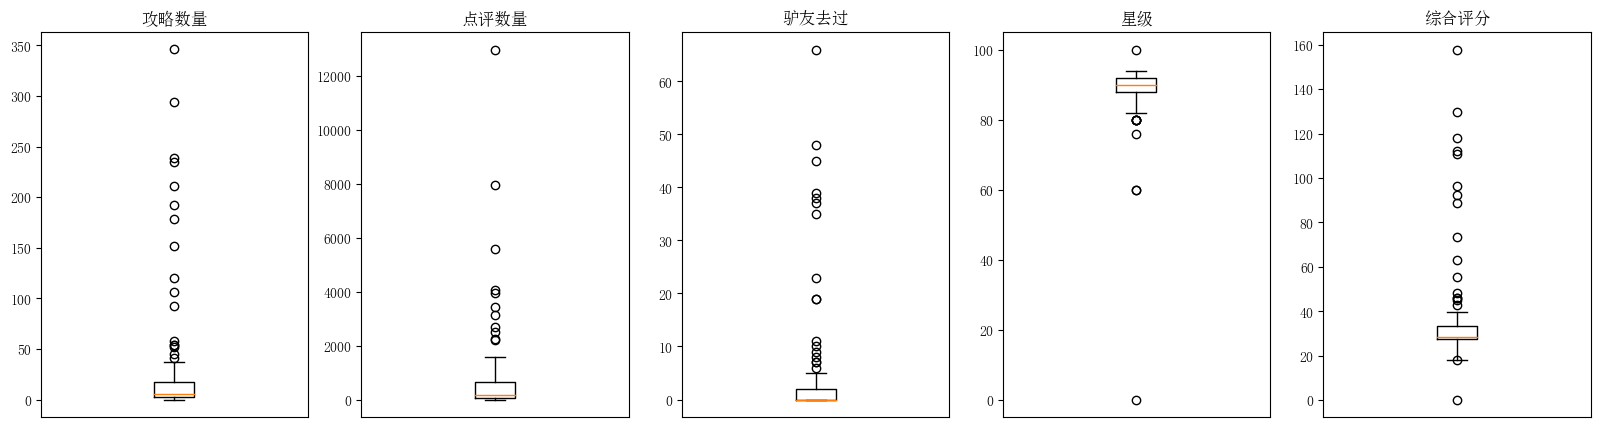

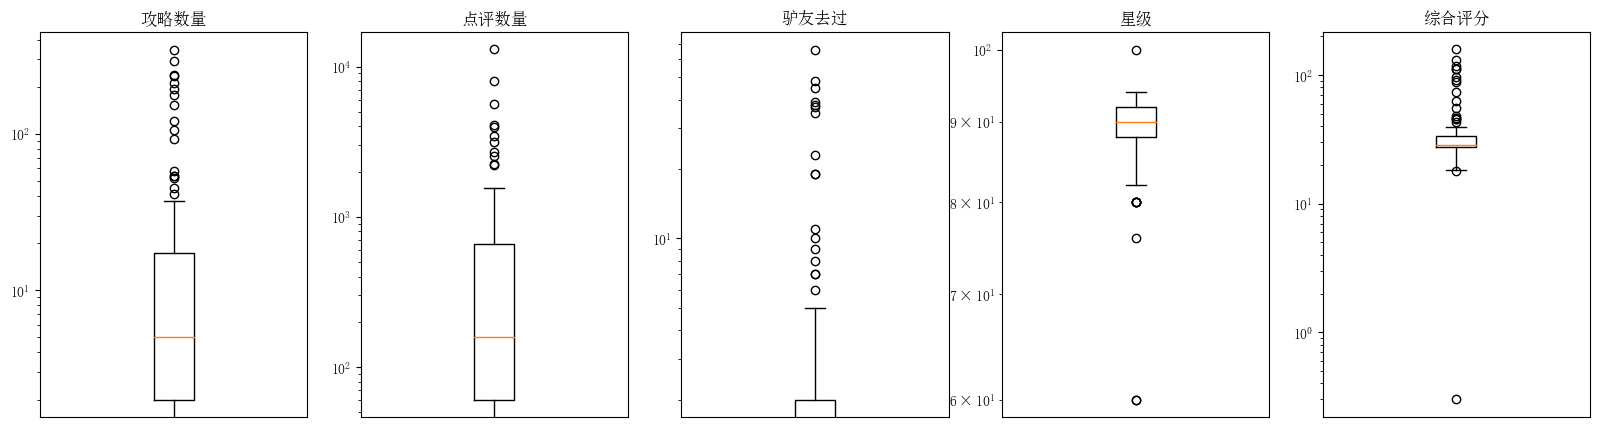

In [12]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
cols = ['攻略数量','点评数量','驴友去过','星级','综合评分']
for i, col in enumerate(cols):
    ax[i].boxplot(df[col])
    ax[i].set_title(col)
    ax[i].set_xticks([])
    # ax[i].set_yscale('log')

fig, ax = plt.subplots(1,5, figsize=(20,5))
cols = ['攻略数量','点评数量','驴友去过','星级','综合评分']
for i, col in enumerate(cols):
    ax[i].boxplot(df[col])
    ax[i].set_title(col)
    ax[i].set_xticks([])
    ax[i].set_yscale('log')

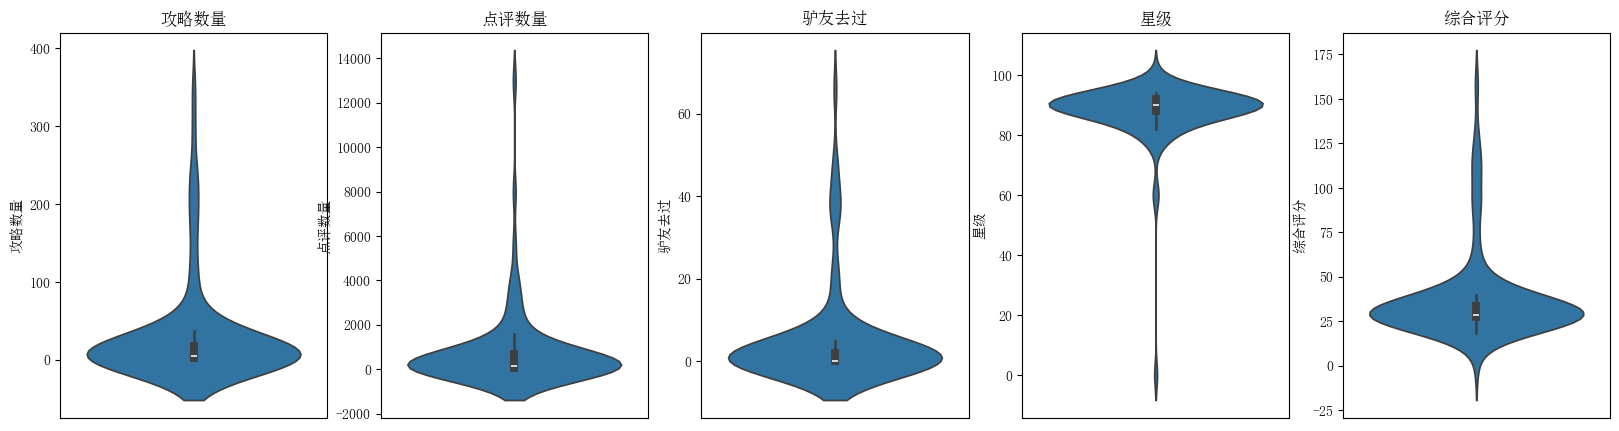

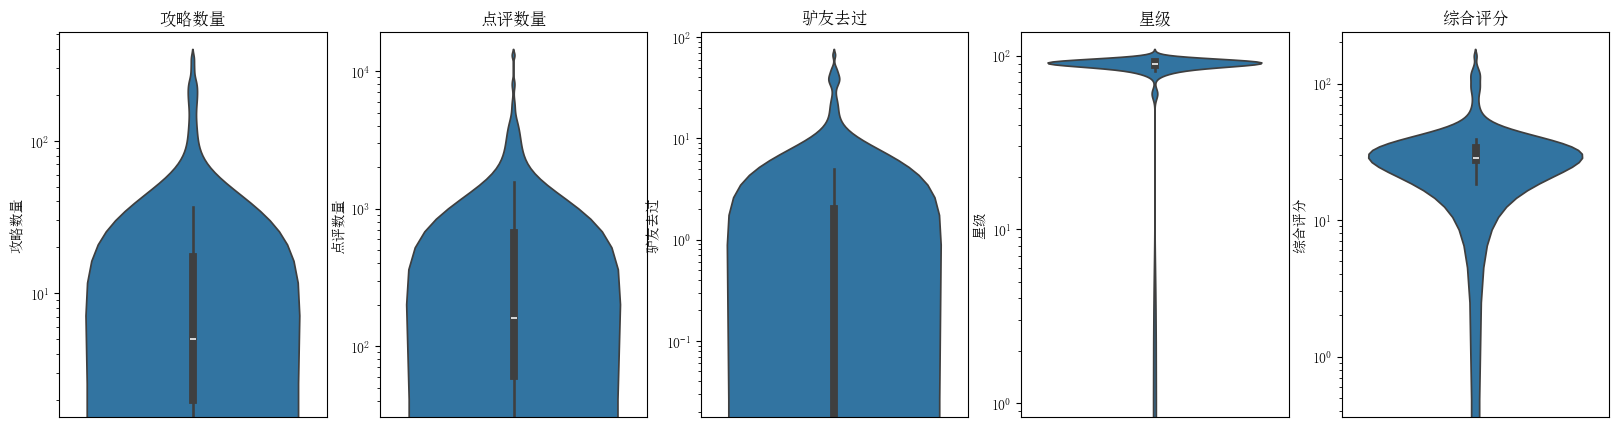

In [13]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
cols = ['攻略数量','点评数量','驴友去过','星级','综合评分']
for i, col in enumerate(cols):
    sns.violinplot(df[col], ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticks([])
    # ax[i].set_yscale('log')
    
fig, ax = plt.subplots(1,5, figsize=(20,5))
cols = ['攻略数量','点评数量','驴友去过','星级','综合评分']
for i, col in enumerate(cols):
    sns.violinplot(df[col], ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticks([])
    ax[i].set_yscale('log')

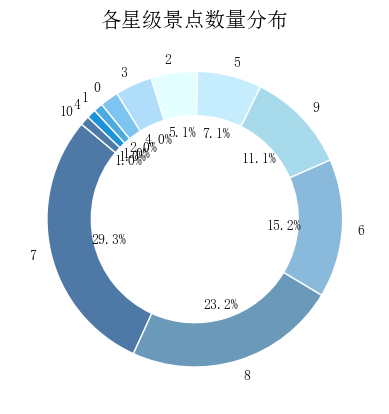

In [14]:
df1 = df.query('星级>0').groupby('星级').size().reset_index(name='count')
df1['星级'] = df1.index

# 饼状
colors = ['#4e79a7', '#6b99b9', '#89badb', '#a7dbeb', '#c5edfd', '#e3ffff', '#b0ddfa', '#7dc4f0', '#4baadf', '#1a91d8']
df2 = df1.sort_values('count', ascending=False)
plt.pie(df2['count'], labels=df2['星级'], autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3, edgecolor='w'), colors=colors)
plt.title('各星级景点数量分布', fontsize=15)
plt.show()

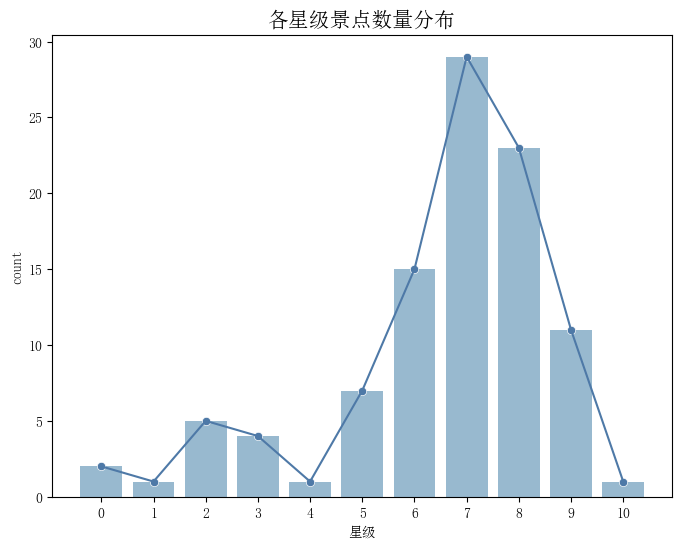

In [15]:
plt.figure(figsize=(8,6))
sns.barplot(df1, x='星级', y='count', alpha=0.5)
sns.lineplot(df1, x='星级', y='count', color='#4e79a7')
sns.scatterplot(df1, x='星级', y='count', color='#4e79a7')
plt.title('各星级景点数量分布', fontsize=15)
plt.show()

In [16]:
# 文本预处理
def preprocess_text(text):
    import re
    # 去除特殊字符
    text = re.sub(r'\W', ' ', text)
    # 使用jieba分词
    words = jieba.lcut(text)
    # 去除停用词
    words = [word for word in words if word not in stop_words]
    words = [word.strip() for word in words if word.strip()]  # 去除空格
    return words

In [17]:
df0 = df.query('描述!="暂无数据"').copy()

stop_words = [line.strip() for line in open('data/stopwords_full.txt', encoding='utf-8').readlines()]
df0['word'] = df['描述'].apply(preprocess_text)

Building prefix dict from the default dictionary ...
Loading model from cache E:\AppData\Temp\Temp\jieba.cache
Loading model cost 0.506 seconds.
Prefix dict has been built successfully.


In [18]:
# 创建一个词云生成函数
def generate_wordcloud(text, topic=None ,font='Times_SimSun.ttf'):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100, font_path=font).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if topic:
        plt.title(f'主题: {topic}', fontsize=20)
    plt.show()

def return_wordcloud(text, topic=None, colormap='RdBu_r', font='Times_SimSun.ttf'):
    wc = WordCloud(width=1200, height=400, background_color='white', contour_width=10, 
                   contour_color='black', colormap=colormap, max_words=100, font_path=font)
    wordcloud = wc.generate(text)
    return wordcloud

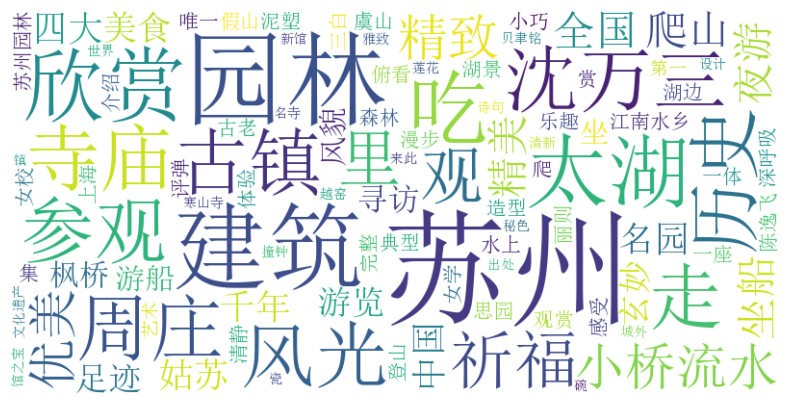

In [19]:
# 针对每个主题生成词云图
words = []
for index, row in df0.iterrows():
    words.append(' '.join(row['word']))
words_text = ' '.join(words)
generate_wordcloud(words_text)

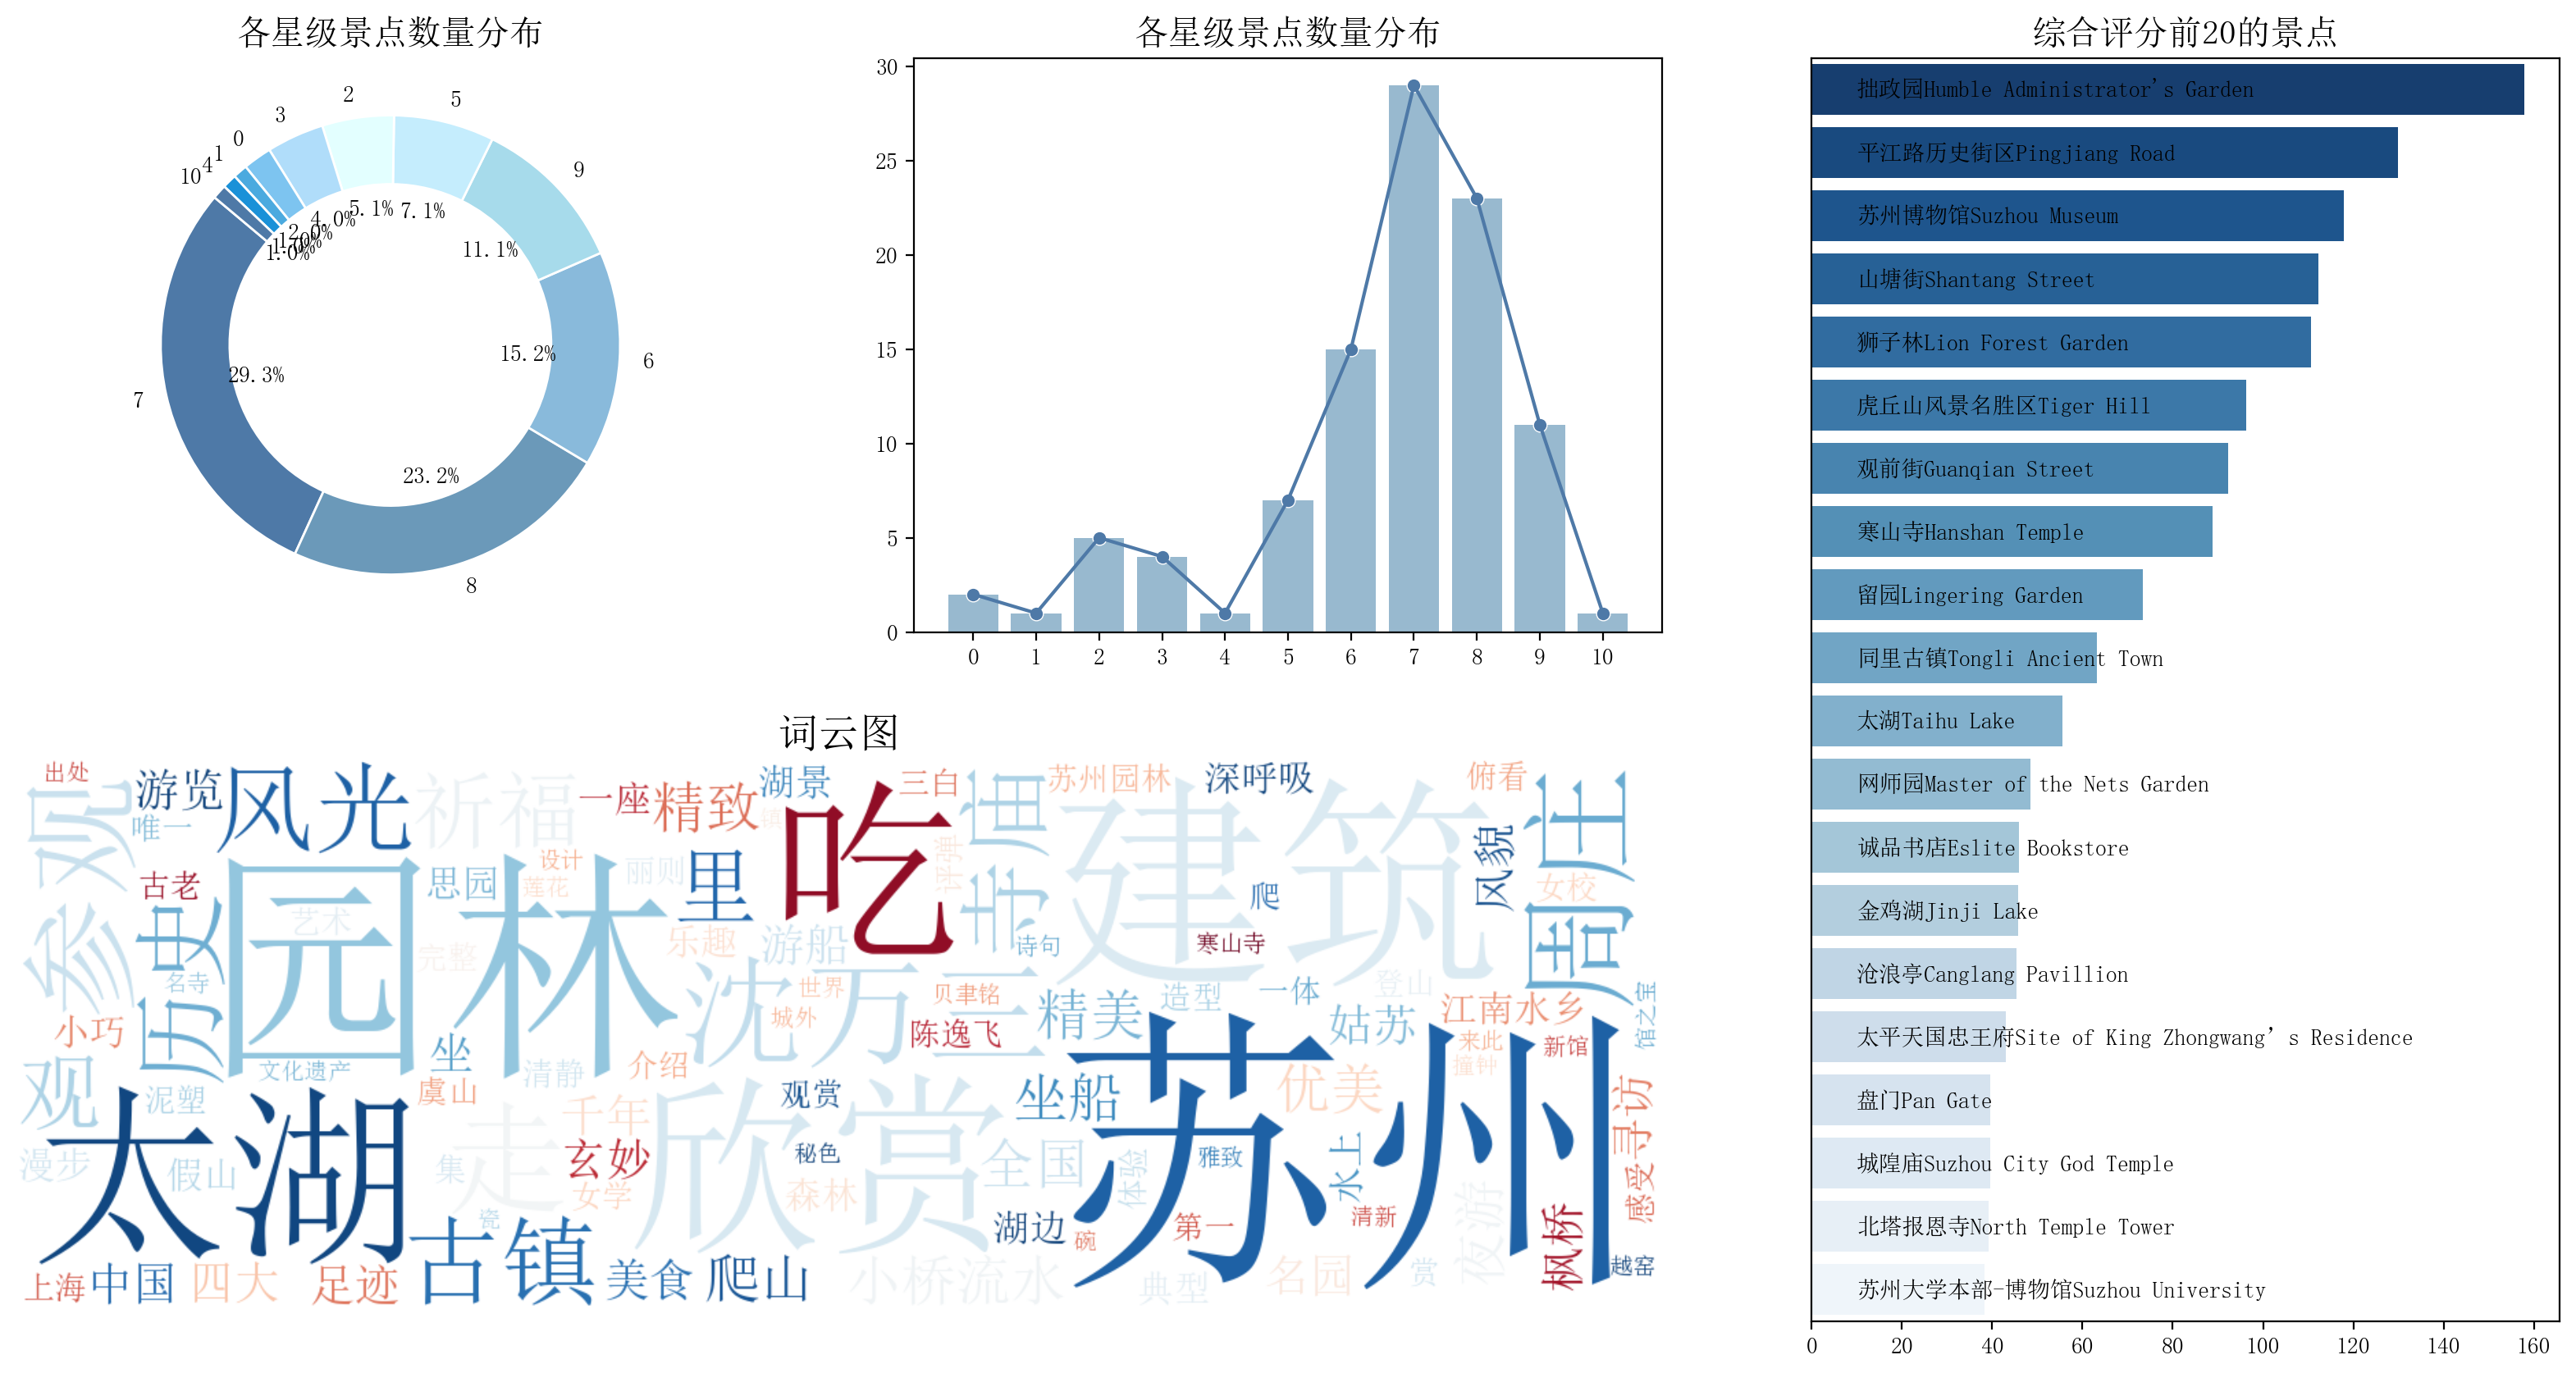

In [20]:
fig = plt.figure(figsize=(20,10), dpi=200)

ax1 = plt.subplot2grid((2,3),(0,0))
ax2 = plt.subplot2grid((2,3),(0,1))
ax3 = plt.subplot2grid((2,3),(0,2), rowspan=2)  # 0,2位置行合并
ax4 = plt.subplot2grid((2,3),(1,0), colspan=2)  # 0,1位置列合并

df1 = df.query('星级>0').groupby('星级').size().reset_index(name='count')
df1['星级'] = df1.index

# 饼状
colors = ['#4e79a7', '#6b99b9', '#89badb', '#a7dbeb', '#c5edfd', '#e3ffff', '#b0ddfa', '#7dc4f0', '#4baadf', '#1a91d8']
df2 = df1.sort_values('count', ascending=False)
ax1.pie(df2['count'], labels=df2['星级'], autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3, edgecolor='w'), colors=colors)
ax1.set_title('各星级景点数量分布', fontsize=15)

# 柱状
sns.barplot(df1, x='星级', y='count', alpha=0.5, ax=ax2)
sns.lineplot(df1, x='星级', y='count', color='#4e79a7', ax=ax2)
sns.scatterplot(df1, x='星级', y='count', color='#4e79a7', ax=ax2)
ax2.set_title('各星级景点数量分布', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('')

# 柱状图
sns.barplot(data=df.sort_values('综合评分',ascending=False).head(20), y='景点名称', x='综合评分', hue='景点名称', palette='Blues_r', ax=ax3)
ax3.set_title('综合评分前20的景点', fontsize=15)
ax3.set_xlabel('')
ax3.set_ylabel('')
# 获取x轴刻度位置和标签
ticks = ax3.get_yticks()
tick_labels = ax3.get_yticklabels()
# 绘制刻度标签
for i, (tick, label) in enumerate(zip(ticks, tick_labels)):
    ax3.text(10, tick, label.get_text(), va='center', ha='left', fontsize=10)
ax3.set_yticks([])

# 使用generate_wordcloud函数生成词云对象，然后在指定的子图上显示
wordcloud = return_wordcloud(words_text, colormap='RdBu_r')
ax4.imshow(wordcloud, interpolation='bilinear')
ax4.axis('off')
ax4.set_title('词云图',fontsize=18)

# plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()